**NOTE**
The Trackman data is confidential, so the data used in this script is only to test 

## Load data

In [2]:


from pathlib import Path

from numpy import log10
import torch
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from custom_transforms import LoadSpectrogram, NormalizeSpectrogram, ToTensor, InterpolateSpectrogram
from data_management import make_dataset_name
from models import weights_init_uniform_rule, SpectrVelCNNRegr, ResNet

# from modular_train_test import train_one_epoch

MODEL = ResNet
LEARNING_RATE = 10**(-3.46)
WEIGHT_DECAY = 10**(-5.39)
EPOCHS = 350 # the model converges in test perfermance after ~250-300 epochs
BATCH_SIZE = 16
NUM_WORKERS = 0
OPTIMIZER = torch.optim.Adam
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# Paths
DATA_ROOT = Path("../data")
STMF_FILENAME = "stmf_data_3.csv"
train_dir = DATA_ROOT / "train"
validation_dir = DATA_ROOT / "validation"

# Transforms
TRAIN_TRANSFORM = Compose([
    LoadSpectrogram(root_dir=train_dir),
    # NormalizeSpectrogram(),
    ToTensor(),
    lambda x: x.permute(1, 2, 0),
    # InterpolateSpectrogram(size=(74, 918))
])

VALIDATION_TRANSFORM = Compose([
    LoadSpectrogram(root_dir=validation_dir),
    # NormalizeSpectrogram(),
    ToTensor(),
    lambda x: x.permute(1, 2, 0),
    # InterpolateSpectrogram(size=(74, 918))
])

train_dataset = MODEL.dataset(data_dir= DATA_ROOT / "train",
                        stmf_data_path = DATA_ROOT / STMF_FILENAME,
                        transform=TRAIN_TRANSFORM)

validation_dataset = MODEL.dataset(data_dir= DATA_ROOT / "validation",
                        stmf_data_path = DATA_ROOT / STMF_FILENAME,
                        transform=VALIDATION_TRANSFORM)

train_data_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Test the dataloaders
for batch in train_data_loader:
    print(batch["spectrogram"].shape)
    print(batch["target"].shape)
    break


torch.Size([16, 6, 74, 918])
torch.Size([16])


## Set up model

In [5]:
model = MODEL().to(DEVICE)
model.apply(weights_init_uniform_rule)

optimizer = OPTIMIZER(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [6]:
def train_one_epoch(loss_fn, model, train_data_loader):
    running_loss = 0.
    last_loss = 0.
    total_loss = 0.

    for i, data in enumerate(train_data_loader):

        spectrogram, target = data["spectrogram"].to(DEVICE), data["target"].to(DEVICE) # Use only the 5th channel, keep channel dimension
        # Add some noise to the spectro for data augmentation
        #spectrogram = spectrogram + torch.randn_like(spectrogram) * 0.1
        # # Shift the spectrogram horizontally
        # shift = torch.randint(-10, 10, (1,)).item()
        # spectrogram = torch.roll(spectrogram, shifts=shift, dims=-1)
        
        optimizer.zero_grad()

        outputs = model(spectrogram)

        # Compute the loss and its gradients
        loss = loss_fn(outputs.squeeze(), target)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        total_loss += loss.item()
        if i % train_data_loader.batch_size == train_data_loader.batch_size - 1:
            last_loss = running_loss / train_data_loader.batch_size # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return total_loss / (i+1)

## Perform training

In [7]:
out_dict = {
        "loss": [],
        "rmse": [],
        "log_rmse": [],
        "test_loss": [],
        "test_rmse": [],
        "log_test_rmse": [],
    }
print(out_dict['loss'])
out_dict['loss'].append(2)
EPOCHS = 20
epoch_number = 0
best_vloss = 10000
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on
    model.train(True)

    # Do a pass over the training data and get the average training MSE loss
    avg_loss = train_one_epoch(MODEL.loss_fn, model, train_data_loader)
    
    # Calculate the root mean squared error: This gives
    # us the opportunity to evaluate the loss as an error
    # in natural units of the ball velocity (m/s)
    rmse = avg_loss**(1/2)

    # Take the log as well for easier tracking of the
    # development of the loss.
    log_rmse = log10(rmse)

    # Reset test loss
    running_test_loss = 0.

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient computation and evaluate the test data
    with torch.no_grad():
        for i, vdata in enumerate(validation_data_loader):
            # Get data and targets
            spectrogram, target = vdata["spectrogram"].to(DEVICE), vdata["target"].to(DEVICE)  # Use only the 5th channel, keep channel dimension
            
            # Get model outputs
            test_outputs = model(spectrogram)

            # Calculate the loss
            test_loss = MODEL.loss_fn(test_outputs.squeeze(), target)

            # Add loss to runnings loss
            running_test_loss += test_loss

    # Calculate average test loss
    avg_test_loss = running_test_loss / (i + 1)

    # Calculate the RSE for the training predictions
    test_rmse = avg_test_loss**(1/2)

    # Take the log as well for visualisation
    log_test_rmse = torch.log10(test_rmse)

    print('LOSS train {} ; LOSS validation {}'.format(avg_loss, avg_test_loss))
    
    # log metrics to wandb
    # result_dict = {
    #     "loss": avg_loss,
    #     "rmse": rmse,
    #     "log_rmse": log_rmse,
    #     "test_loss": avg_test_loss,
    #     "test_rmse": test_rmse,
    #     "log_test_rmse": log_test_rmse,
    # }
    # print(result_dict)
    out_dict['loss'].append(avg_loss)
    out_dict['rmse'].append(rmse)
    out_dict['log_rmse'].append(log_rmse)
    out_dict['test_loss'].append(test_loss.item())
    out_dict['test_rmse'].append(test_rmse.item())
    out_dict['log_test_rmse'].append(log_test_rmse.item())
    # Track best performance, and save the model's state
    if avg_test_loss < best_vloss:
        best_vloss = avg_test_loss
        # torch.save(model.state_dict(), model_path)

    epoch_number += 1

[]
EPOCH 1:
  batch 16 loss: 503.00030994415283
LOSS train 432.1904159345125 ; LOSS validation 37.56476593017578
EPOCH 2:


KeyboardInterrupt: 

## Plot learning curves

Text(0, 0.5, 'Accuracy')

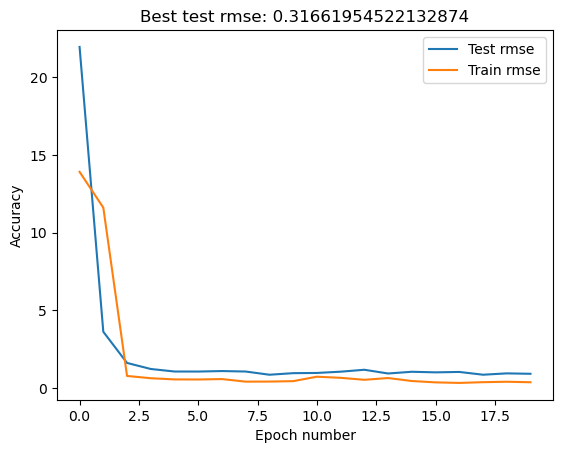

In [66]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(out_dict['rmse'], label='Train rmse')
plt.plot(out_dict['test_rmse'], label='Validation rmse')
plt.title(f'Best test rmse: {np.min(out_dict['test_rmse'])}')
plt.legend(('Test rmse','Train rmse'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')

## Get test data

In [9]:
test_dir = DATA_ROOT / "test"

TEST_TRANSFORM = Compose([
    LoadSpectrogram(root_dir=test_dir),
    ToTensor(),
    lambda x: x.permute(1, 2, 0)
])

test_dataset = MODEL.dataset(data_dir= DATA_ROOT / "test",
                        stmf_data_path = DATA_ROOT / STMF_FILENAME,
                        transform=TEST_TRANSFORM)

test_data_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [10]:
images = next(iter(test_data_loader))
input_tensor, labels = images["spectrogram"].to(DEVICE), images["target"].to(DEVICE)

original_image_first_channel = input_tensor[0, 0, :, :].detach().cpu().numpy()
input_tensor = input_tensor[0,:,:,:]
labels = labels[0]

## Make saliency maps

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

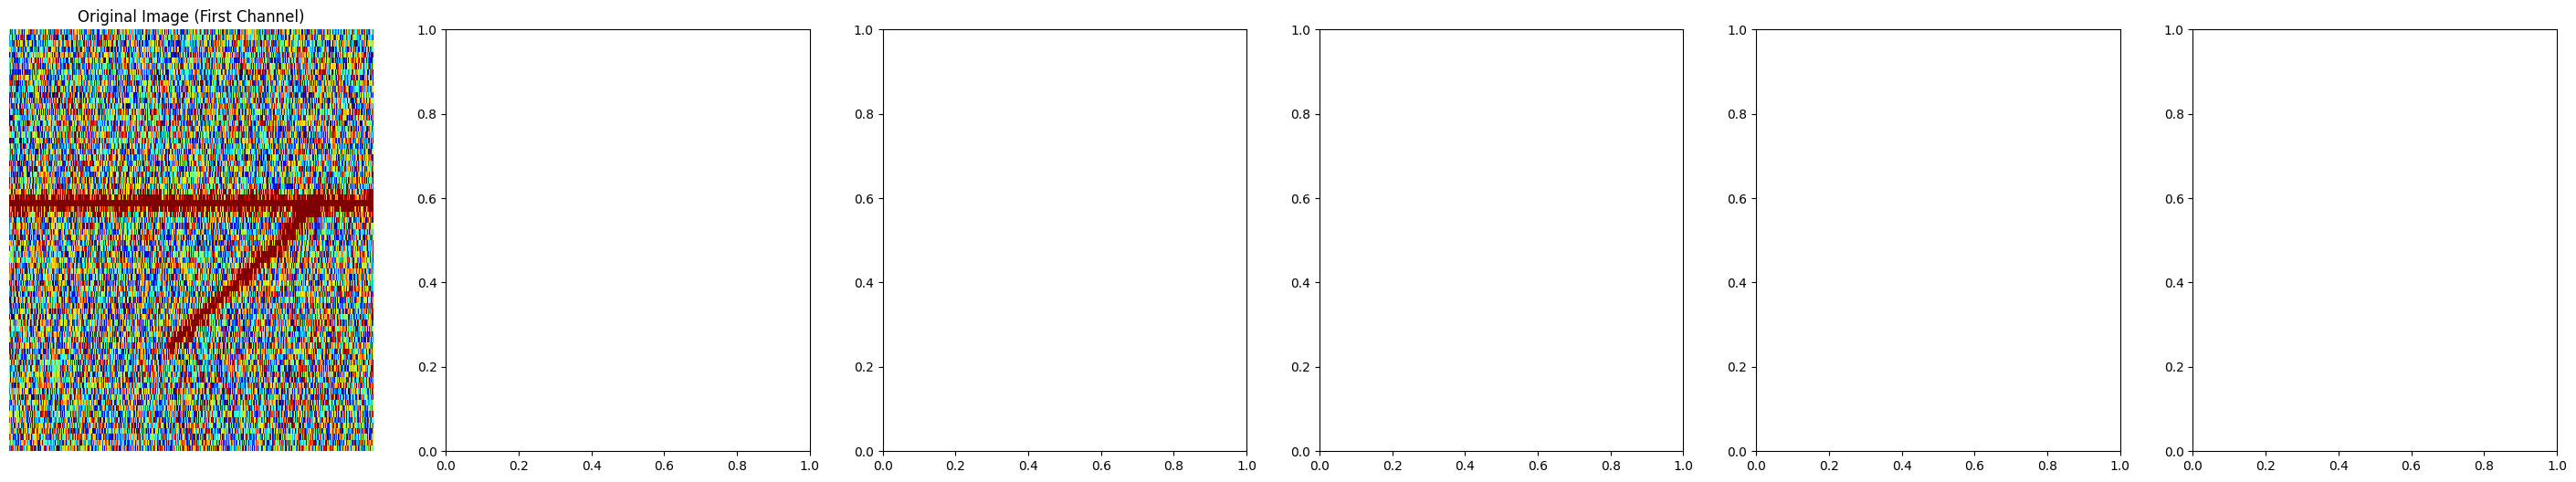

In [12]:
# from saliency import smooth_grad
import importlib
import saliency
importlib.reload(saliency)
from saliency import smooth_grad
import matplotlib.pyplot as plt

TS_CROPTWIDTH = (-150, 200)
VR_CROPTWIDTH = (-60, 15)

fig, axs = plt.subplots(1, 6, figsize=(36, 6))
axs[0].imshow(original_image_first_channel, aspect="auto", 
    extent=[TS_CROPTWIDTH[0]/1000,TS_CROPTWIDTH[1]/1000,
            VR_CROPTWIDTH[0],VR_CROPTWIDTH[1]],
    origin="upper",
    interpolation='nearest',
    cmap="jet")
axs[0].set_title("Original Image (First Channel)")
axs[0].axis('off')

print
for i in range(1, 6):
    std = 0.05*i
    saliency_map = smooth_grad(model, input_tensor, labels, num_samples=50, noise_level=std, device=DEVICE)

    # Extract the first channel of the original image

    # Ensure the saliency map is in the correct shape
    saliency_map_reshaped = saliency_map.squeeze()

    # Create the figure with two subplots


    # Plot the saliency map on the right
    axs[i].imshow(saliency_map_reshaped, origin='upper', aspect="auto", 
        extent=[TS_CROPTWIDTH[0]/1000,TS_CROPTWIDTH[1]/1000,
                VR_CROPTWIDTH[0],VR_CROPTWIDTH[1]],
        interpolation='nearest',
        cmap='hot')
    axs[i].set_title(f"Saliency Map (std={std})")
    axs[i].axis('off')

# Save the figure
# plt.tight_layout()
# plt.savefig(f"plots/saliency_map_comparison_}.png", dpi=300)
plt.show()